In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
# Extract file from zip
import os
import shutil
import zipfile

os.makedirs('data', exist_ok=True)
with zipfile.ZipFile('financial-news-data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

,text,label
0,Here are Thursday's biggest analyst calls: App...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",Analyst Update
4,Netflix and its peers are set for a ‘return to...,Analyst Update


<StringArray>
[             'Analyst Update',      'Company | Product News',
      'General News | Opinion',                  'Currencies',
                    'Dividend',                    'Earnings',
                'Energy | Oil',         'Fed | Central Banks',
                  'Financials',   'Gold | Metals | Materials',
                         'IPO',          'Legal | Regulation',
           'M&A | Investments',                       'Macro',
                     'Markets',            'Personnel Change',
                    'Politics',            'Stock Commentary',
              'Stock Movement', 'Treasuries | Corporate Debt']
Length: 20, dtype: str


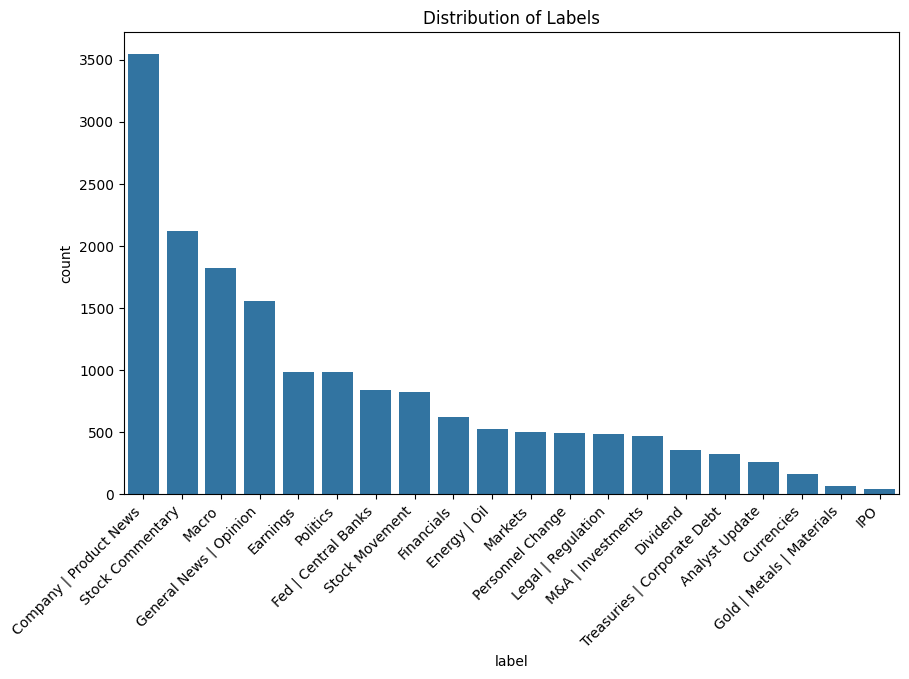

label
Company | Product News         3545
Stock Commentary               2118
Macro                          1822
General News | Opinion         1557
Earnings                        987
Politics                        985
Fed | Central Banks             837
Stock Movement                  823
Financials                      624
Energy | Oil                    524
Markets                         501
Personnel Change                495
Legal | Regulation              487
M&A | Investments               471
Dividend                        359
Treasuries | Corporate Debt     321
Analyst Update                  255
Currencies                      166
Gold | Metals | Materials        69
IPO                              44
Name: count, dtype: int64


In [3]:
train_df = pd.read_csv("./data/financial-news-train.csv")
test_df = pd.read_csv("./data/financial-news-test.csv")

display(train_df.head())

# Simple EDA
# Check for unique labels
print(train_df['label'].unique())

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print value counts
print(train_df['label'].value_counts())

# Logistic Regression

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # เลือก (???) ว่าจะ represent ยังไง
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Cleaning
def preprocessing(data_df):
    data_df['text'] = data_df['text'].fillna("")
    return data_df
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

"""
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']
....
# just use pipeline ToT
"""
pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('lr_clf', LogisticRegression(max_iter=1000))
])


pipe.fit(train_df['text'], train_df['label']) #fit(X_train,y_train)
predictions_lr = pipe.predict(test_df['text'])
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('lr_clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


# Zero-shot LLM 

In [ ]:
# TODO: implement batch prompting for gemini to counter rate limits
# Gemini (Thank you Copilot)
import time
from tqdm.auto import tqdm # Progress bar
from google import genai
import os
from dotenv import load_dotenv
load_dotenv()

# 0. Setup Client (Ensure 'GEMINI_API_KEY' is in .env)
client = genai.Client(api_key = os.environ.get("GEMINI_API_KEY"))

# 1. Identify Labels and Create Label Descriptions
labels = train_df['label'].unique().tolist()
# TODO: implement better prompt design as per [2.2 (1)]
label_desc_map = {
    'Analyst Update': 'News regarding stock ratings, analyst upgrades/downgrades, or price targets.',
    'Macro': 'News about the broader economy, inflation, central banks, GDP, or government policy.',
    'Earnings': 'News related to company financial results, revenue, profits, or quarterly reports.',
    'Treasuries | Corporate Debt': 'News about bonds, yields, debt markets, or corporate borrowing.',
    'Dividend': 'News specifically about dividend declarations, payouts, or changes.',
    'Commodities': 'News about raw materials like oil, gold, wheat, or metals.',
    'Fed | Central Banks': 'News about the Federal Reserve, interest rates, or central bank decisions.',
    # Add other labels if they exist in your dataset
}

# 2. Templatized Prompt Function
def get_llm_prompt(text):
    # Construct label list string
    #label_list_str = "\n".join([f"- {lbl}: {desc}" for lbl, desc in label_desc_map.items()])
    label_list_str = "\n".join([f"- {label}" for label in labels])
    
    # Template
    prompt = f"""You are an expert financial news classifier.
Your task is to classify the provided news text into exactly one of the following categories:

{label_list_str}

Output Format:
Return ONLY the category name. Do not include any explanations or extra text.

Input Text:
"{text}"

Category:"""
    return prompt

# 3. Prediction Function
def get_llm_prediction(text):
    prompt = get_llm_prompt(text)
    try:
        # Using Gemini as per your setup
        response = client.models.generate_content(
            model="gemini-3-flash-preview", 
            contents=prompt
        )
        return response.text.strip()
    except Exception as e:
        print(f"Error: {e}")
        return "Error"

# 4. Run on a Sample (Assignment Suggestion: Use 100 rows if full set is too slow)
sample_size = 100 
#sample_test_df = test_df.sample(n=sample_size, random_state=42).copy()
sample_test_df = test_df.copy()
print(f"Running LLM on {sample_size} samples...")
llm_preds = []

for i, row in tqdm(sample_test_df.iterrows(), total=sample_test_df.shape[0]):
    pred = get_llm_prediction(row['text'])
    llm_preds.append(pred)
    
    time.sleep(1) # TODO: Adjust sleep if encounter 429 error (Gemini free tier is 15 requests per min (4 sec sleep))
sample_test_df['llm_pred'] = llm_preds
sample_test_df.to_csv("pred_gemini3f_max.csv")

Running LLM on 100 samples...


  0%|          | 0/4117 [00:00<?, ?it/s]

Error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-3-flash\nPlease retry in 18.934170104s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-3-flash'}, 'quotaV

KeyboardInterrupt: 

In [ ]:
# Typhoon (Again, thank you copilot)
import os
import time
from tqdm.auto import tqdm # progress bar so I'm not looking insane
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

# 1. Setup Typhoon Client
client = OpenAI(
    base_url="https://api.opentyphoon.ai/v1", # Typhoon API Endpoint
    api_key=os.environ.get("TYPHOON_API_KEY"), # Or paste your key directly string here
)

# 2. Identify Labels 
labels = train_df['label'].unique().tolist()
# TODO: implement better prompt design as per [2.2 (1)]
label_desc_map = { # Add description to improve (???) accuracy
    'Analyst Update': 'News regarding stock ratings, analyst upgrades/downgrades, or price targets.',
    'Macro': 'News about the broader economy, inflation, central banks, GDP, or government policy.',
    'Earnings': 'News related to company financial results, revenue, profits, or quarterly reports.',
    'Treasuries | Corporate Debt': 'News about bonds, yields, debt markets, or corporate borrowing.',
    'Dividend': 'News specifically about dividend declarations, payouts, or changes.',
    'Commodities': 'News about raw materials like oil, gold, wheat, or metals.',
    'Fed | Central Banks': 'News about the Federal Reserve, interest rates, or central bank decisions.',
    # TODO:  Add descriptions for other labels in `train_df['label'].unique()` -> do when needed & not lazy
}

# 3. Templatized Prompt Function
def get_llm_prompt(text):
    #label_list_str = "\n".join([f"- {lbl}: {desc}" for lbl, desc in label_desc_map.items()])
    label_list_str = "\n".join([f"- {label}" for label in labels])
    
    # Q4: THIS IS THE PROMPT I"M USING!
    prompt = f"""You are an expert financial news classifier.  
Your task is to classify the provided news text into exactly one of the following categories:

{label_list_str} # Context caching (???) [2.2 (1)]

Output Format:
Return ONLY the category name. Do not include any explanations or extra text.

Input Text:
"{text}"

Category:"""
    return prompt

# 4. Prediction Function (Typhoon)
def get_llm_prediction(text):
    prompt = get_llm_prompt(text)
    try:
        response = client.chat.completions.create(
            model="typhoon-v2.5-30b-a3b-instruct", # As recommended in assignment
            messages=[
                {"role": "user", "content": prompt}
            ],
            max_tokens=512, # TODO: change this to match needed
            temperature=0 # Deterministic output
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error: {e}")
        return "Error"

# 5. Run on a Sample 
# TODO: change this for max number of records
sample_size = 1000
sample_test_df = test_df.copy()
#sample_test_df = test_df.sample(n=sample_size, random_state=42).copy() 

print(f"Running Typhoon LLM on {sample_size} samples...")
llm_preds = []

#for i, row in sample_test_df.iterrows():
for i, row in tqdm(sample_test_df.iterrows(), total = sample_test_df.shape[0]):    
    pred = get_llm_prediction(row['text'])
    llm_preds.append(pred)
    # Typhoon has generous rate limits, but good to be safe
    time.sleep(0.2) 

sample_test_df['llm_pred'] = llm_preds
sample_test_df.to_csv("pred_typhoon.csv")

Running Typhoon LLM on 1000 samples...


  0%|          | 0/4117 [00:00<?, ?it/s]

In [ ]:
# Let's look at the predictions 
# Saving format: pred_{model}_{dataset}_{#samples}
#sample_test_df.to_csv("typhoon_test_max.csv")
#sample_test_df.sample(5)

# TODO: batch

,text,label,llm_pred
185,$BTBT: Bit Digital announces monthly productio...,Company | Product News,Company | Product News
4000,$MDGS (+14.0% pre) Medigus: Polyrizon Signed a...,Stock Movement,Stock Commentary
2971,Monroe Capital Hires Matthew Rosenberg to Head...,Personnel Change,Personnel Change
933,Euro rallies and bund yields jump after half-p...,Currencies,Markets
3331,$SPY $QQQ update. Hard bounce off 2 week ascen...,Stock Commentary,Stock Commentary


In [ ]:
# Is the model hallucinating labels?
ground_truth_labels = set(test_df['label'].unique())
llm_predicted_labels = set(sample_test_df['llm_pred'].unique())

mismatched = llm_predicted_labels - ground_truth_labels
print(f"Labels predicted by LLM but not in Test Data: {mismatched}")

# Cleaning
sample_test_df['llm_pred'] = sample_test_df['llm_pred'].str.strip()

Labels predicted by LLM but not in Test Data: {'ETF | Mutual Fund News', 'Inflation Data', 'Commodities | Materials', 'Currency', 'Macau\'s gambling revenue has been significantly impacted by Beijing\'s stringent "Covid-zero" policies, which have restricted travel and kept Chinese gamblers within the country, preventing them from visiting Macau. This has resulted in a notable shortfall compared to Las Vegas, which has seen a stronger recovery in gaming revenues as travel restrictions eased globally. The ongoing situation underscores how public health policies can directly influence regional economic performance, particularly in tourism-dependent economies like Macau.\n\nCategory: Macau', 'Trade Deficit', 'Mortgage Applications', 'Macroeconomic', 'Commodities', 'Mortgage Rates', 'Real Estate | Housing', 'ETF Launch | Investment Strategy', 'Inflation | Consumer Prices', 'CPI', 'Default', 'Mortgage rates jump after two weeks of declines  https://t.co/Y3yQ45dmJW by @__gabriellacruz  \n\nSt

text        42
label       42
llm_pred    42
dtype: int64

# Evaluation

In [57]:
pred_typhoon = pd.read_csv("./pred_typhoon_test_max.csv")
pred_typhoon.head()

,Unnamed: 0,text,label,llm_pred
0,0,Analyst call of the day for @CNBCPro subscribe...,Analyst Update,Analyst Update
1,1,"Loop upgrades CSX to buy, says it's a good pla...",Analyst Update,Stock Commentary
2,2,BofA believes we're already in a recession — a...,Analyst Update,Stock Commentary
3,3,JPMorgan sees these derivative plays as best w...,Analyst Update,Stock Commentary
4,4,Morgan Stanley's Huberty sees Apple earnings m...,Analyst Update,Stock Commentary


In [ ]:
# Comparing models
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
print("Logistic Regression Performance:")
print(classification_report(test_df['label'], predictions_lr)) #Q1: precision, recall, f1 for each label in test.csv
print ("----" * 20)

# Q5: llm (especially typhoon) performs worse in both classification accuracy & resource spent (time & compute)
print ("Zero-shot LLM Performance")
print (f"There are {sample_test_df[sample_test_df['llm_pred'].isin(mismatched)].shape[0]} predictions with hallucinated label")
print(classification_report(test_df['label'], 
                            sample_test_df['llm_pred'],
                            labels=list(ground_truth_labels),
                            zero_division=0
                            ))

Logistic Regression Performance:
                             precision    recall  f1-score   support

             Analyst Update       0.98      0.63      0.77        73
     Company | Product News       0.80      0.88      0.84       852
                 Currencies       0.88      0.66      0.75        32
                   Dividend       0.98      0.97      0.97        97
                   Earnings       0.94      0.92      0.93       242
               Energy | Oil       0.82      0.77      0.79       146
        Fed | Central Banks       0.85      0.82      0.84       214
                 Financials       0.86      0.85      0.85       160
     General News | Opinion       0.73      0.74      0.74       336
  Gold | Metals | Materials       0.38      0.46      0.41        13
                        IPO       0.83      0.71      0.77        14
         Legal | Regulation       0.93      0.72      0.82       119
          M&A | Investments       0.83      0.59      0.69       116


In [ ]:
# Feature Importance
def print_all_top_features(pipeline, n=10):
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['lr_clf']
    feature_names = vectorizer.get_feature_names_out()
    
    classes = classifier.classes_
    coefs = classifier.coef_
    
    print("\n--- Feature Importance by Class ---")
    for i, class_label in enumerate(classes):
        # Get indices of top n largest coefficients
        top_indices = coefs[i].argsort()[-n:][::-1]
        top_features = [feature_names[j] for j in top_indices]
        print(f"\nLabel: {class_label}")
        print(f"Top {n} words: {', '.join(top_features)}")
        
def print_specific_top_features(pipeline, class_labels, n=10):
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['lr_clf']
    feature_names = vectorizer.get_feature_names_out()
    
    classes = classifier.classes_
    coefs = classifier.coef_
    
    # If a single string is passed, wrap it in a list
    if isinstance(class_labels, str):
        class_labels = [class_labels]
    
    print("\n--- Feature Importance by Class ---")
    for class_label in class_labels:
        if class_label in classes:
            
            i = list(classes).index(class_label) # Find the index of the class label in the model's classes
            
            # Get indices of top n largest coefficients
            top_indices = coefs[i].argsort()[-n:][::-1]
            top_features = [feature_names[j] for j in top_indices]
            print(f"\nLabel: {class_label}")
            print(f"Top {n} words: {', '.join(top_features)}")
        else:
            print(f"\nLabel: {class_label} not found in model.")
        
print_all_top_features(pipe, n=10)


--- Feature Importance by Class ---

Label: Analyst Update
Top 10 words: downgrades, analyst, ratings, analysts, downgraded, barclays, target, upgrades, citing, outperform

Label: Company | Product News
Top 10 words: launches, expands, receives, split, partnership, amazon, bankruptcy, introduces, msc, letter

Label: Currencies
Top 10 words: dollar, euro, usd, rupee, yen, currency, yuan, parity, hike, outflows

Label: Dividend
Top 10 words: dividend, declares, distribution, announces, dividends, distributions, quarterly, trust, monthly, reit

Label: Earnings
Top 10 words: earnings, results, conference, q2, reports, 2022, quarter, upcoming, preview, profit

Label: Energy | Oil
Top 10 words: oil, crude, gas, opec, prices, lng, energy, coal, futures, gasoline

Label: Fed | Central Banks
Top 10 words: fed, ecb, yellen, rates, rate, imf, boe, reserve, bank, central

Label: Financials
Top 10 words: revenue, beats, profit, gaap, guidance, misses, eps, q2, earnings, sales

Label: General News 

In [ ]:
report_dict = classification_report(test_df['label'], predictions_lr, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
# Settings
n=2
metric ="f1-score"
# Remove summary rows to analyze only specific labels
label_perf = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
topNlabel = label_perf.sort_values(by=metric, ascending=False).head(n)
botNlabel = label_perf.sort_values(by=metric, ascending=True).head(n)

# Q2: 2 best performing labels (dividend & earning reports literally almost always include words such as 'dividend' and 'earning')
print(f"Top {n} performing labels (by {metric}):")
display(topNlabel)
print_specific_top_features(pipeline=pipe, class_labels=list(topNlabel.index), n=10)
print ("----"*30)

# Q3: 2 worst performming labels -> low training data, might look into captured characteristics (like distinct or overused words found)
print("\nBottom 2 performing labels (by f1-score):")
display(botNlabel)
print_specific_top_features(pipeline=pipe, class_labels=list(botNlabel.index), n=10)


Top 2 performing labels (by f1-score):


,precision,recall,f1-score,support
Dividend,0.979167,0.969072,0.974093,97.0
Earnings,0.936709,0.917355,0.926931,242.0



--- Feature Importance by Class ---

Label: Dividend
Top 10 words: dividend, declares, distribution, announces, dividends, distributions, quarterly, trust, monthly, reit

Label: Earnings
Top 10 words: earnings, results, conference, q2, reports, 2022, quarter, upcoming, preview, profit
------------------------------------------------------------------------------------------------------------------------

Bottom 2 performing labels (by f1-score):


,precision,recall,f1-score,support
Gold | Metals | Materials,0.375000,0.461538,0.413793,13.0
M&A | Investments,0.831325,0.594828,0.693467,116.0



--- Feature Importance by Class ---

Label: Gold | Metals | Materials
Top 10 words: gold, metals, copper, settlement, dollar, comdx, prices, nickel, trading, investors

Label: M&A | Investments
Top 10 words: acquires, acquire, acquisition, merger, sale, stake, invests, buy, purchase, spin
